# PageRank

*Data Structures and Information Retrieval in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/DSIRP/blob/main/notebooks/pagerank.ipynb)

## Ranking pages

The goal of information retrieval is to find resources that are relevant and high quality.
"Relevant" and "quality" can be hard to define, and they depend on what kind of resources you are searching.

In the context of web search, relevance usually depends on the contents of a web page: if a web page contains the search terms, we assume that it is relevant to the search terms.

Quality usually depends on the links between pages.
If there are many links to a particular page, we think it is more likely to be high quality, especially if those links come from pages that are high quality themselves.

One of the first algorithms to quantify quality in this is PageRank, which was the core of Google's original search engine.
As someone who used earlier search engines, like Alta Vista, I can tell you first-hand what a big difference it made.

PageRank is described in ["The PageRank citation ranking: Bringing order to the Web"](https://web.archive.org/web/20110818093436/http://ilpubs.stanford.edu:8090/422/1/1999-66.pdf) by  Page, Brin, Motwani, and Winograd.

It is a surprisingly simple algorithm; it can be computed and updated efficiently; and it is highly effective at identifying good quality pages.
So, let's see how it works.

As an example, I'll use `random_k_out_graph` to generate a directed graph with `n` nodes where:

* Every node has the same number of out-links, `k`,

* The number of in-links varies moderately (controlled by the parameter `alpha`).

* Self-links and multiple links are allowed.


In [1]:
import networkx as nx

G = nx.random_k_out_graph(n=8, k=2, alpha=0.75)

Here's what the graph looks like. Multiple links appear as slightly thicker lines.

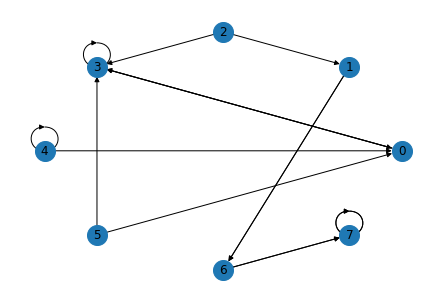

In [2]:
def draw_graph(G):
    nx.draw_circular(G, node_size=400, with_labels=True)
    
draw_graph(G)

NetworkX provides an implementation of PageRank we can use to compute a metric of "importance" for each page.

In [3]:
ranks_pr = nx.pagerank(G)
ranks_pr

{0: 0.17812499999999998,
 1: 0.026718750000000003,
 2: 0.018750000000000003,
 3: 0.3236399407472092,
 4: 0.03261005925279078,
 5: 0.018750000000000003,
 6: 0.0414609375,
 7: 0.35994531249999995}

You should see that nodes with more in-links get higher scores.

##  Random Walk

One way to interpret PageRank is in terms of a random walk.
Suppose you choose a node at random, then choose one of its out-links at random, and continue like that, making a note of each node you visit.

If a node has a lot of in-links, you are likely to visit it more often.
And if those in-links come from nodes with many in-links, even more so.

However, there is one catch: if a node contains no out-links, or if a set of nodes form a loop with no out-links, the random walker could get trapped.

To avoid that, we'll modify the random walk so at every step there is some probability that the walker jumps to a random node rather than following a link.
This probability is determined by a parameter, `alpha`, which is the probability of following a link, so `1-alpha` is the probability of making a random jump.

The following function implements a random walk, with these random jumps, and uses a `Counter` to keep track of the number of times it visits each node.

It returns the `Counter` with the frequencies normalized to add up to one.
If everything goes according to plan, these values should approximate the results from PageRank.

In [4]:
import numpy as np

def flip(p):
    return np.random.random() < p

In [5]:
from collections import Counter

def random_walk(G, alpha=0.85, iters=1000):
    counter = Counter()
    node = next(iter(G))
    
    for _ in range(iters):
        if flip(alpha):
            node = np.random.choice(list(G[node]))
        else:
            node = np.random.choice(list(G))
        
        counter[node] += 1
        
    total = sum(counter.values())
    for key in counter:
        counter[key] /= total
    return counter

The default value of `alpha` is 0.85, which is the same as the default value for `nx.pagerank`.

Here are the scores we get from the random walk.

In [6]:
ranks_rw = random_walk(G)
ranks_rw

Counter({3: 0.285,
         0: 0.168,
         6: 0.041,
         4: 0.034,
         2: 0.023,
         1: 0.03,
         7: 0.401,
         5: 0.018})

To compare them to the results from PageRank, I'll put them in a Pandas `DataFrame`.

In [7]:
import pandas as pd

s1 = pd.Series(ranks_pr)
s2 = pd.Series(ranks_rw)

df = pd.DataFrame(dict(PageRank=s1, RandomWalk=s2))
df['Diff'] = df['RandomWalk'] - df['PageRank']
df*100

,PageRank,RandomWalk,Diff
0,17.812500,16.8,-1.012500
1,2.671875,3.0,0.328125
2,1.875000,2.3,0.425000
3,32.363994,28.5,-3.863994
4,3.261006,3.4,0.138994
5,1.875000,1.8,-0.075000
6,4.146094,4.1,-0.046094
7,35.994531,40.1,4.105469


The differences should be a few percentage points at most.

## Adjacency Matrix

The random walk implementation of PageRank is conceptually simple, but not very efficient to compute.
An alternative is to use a matrix to represent the links from each node to every other node, and compute the eigenvectors of that matrix.

In this section, I'll demonstrate this computation and explain how it works.
The code here is based on the [implementation of PageRank in NetworkX](https://networkx.org/documentation/stable/_modules/networkx/algorithms/link_analysis/pagerank_alg.html).

NetworkX provides a function that creates a NumPy array that represents the [adjacency matrix](https://en.wikipedia.org/wiki/Adjacency_matrix) of the graph.

In [8]:
M = nx.to_numpy_array(G)
M

array([[0., 0., 0., 2., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 2., 0.],
       [0., 1., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 2.],
       [0., 0., 0., 0., 0., 0., 0., 2.]])

In this matrix, the element in row `i`, column `j` indicates the number of edges from node `i` to node `j`.

If we normalize each row so it adds up to one, each element of the result represents the probability of a transition from one node to another.

In [9]:
M /= M.sum(axis=1)
M

array([[0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. ],
       [0. , 0.5, 0. , 0.5, 0. , 0. , 0. , 0. ],
       [0.5, 0. , 0. , 0.5, 0. , 0. , 0. , 0. ],
       [0.5, 0. , 0. , 0. , 0.5, 0. , 0. , 0. ],
       [0.5, 0. , 0. , 0.5, 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. ]])

We can use this matrix to simulate a random walk with many walkers at the same time.
For example, suppose we start with 100 walkers at each node, represented by the array `x`:


In [10]:
N = len(G)
x = np.full(N, 100)
x

array([100, 100, 100, 100, 100, 100, 100, 100])

If we transpose `M`, we get a [transition matrix](https://en.wikipedia.org/wiki/Stochastic_matrix) where the element at row `i` and column `j` is the fraction of walkers at node `j` that move to node `i`.

If we multiply the transition matrix by `x`, the result is an array with the number of walkers at each node after one time step.

In [11]:
x = M.T @ x
x

array([150.,  50.,   0., 250.,  50.,   0., 100., 200.])

If you run that cell a few times, you should find that it converges to a steady state where the number of walkers at each node doesn't change much from one time step to the next.

However, you might notice that some nodes lose all of their walkers.
That's because the random walk we've simulated doesn't include random jumps.

To add random jumps, we can create another matrix that include transitions from all nodes to all other nodes with equal probability.

In [12]:
p = np.full((N, N), 1/N)
p

array([[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
       [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
       [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
       [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
       [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
       [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
       [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
       [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]])

Now we'll use the parameter `alpha` to compute a weighted sum of `M` and `p`. 

In [13]:
alpha = 0.85
GM = alpha * M + (1 - alpha) * p

The result is a "Google matrix" that represents transitions in a random walk, including random jumps.

So let's start again with an equal number of walkers on all nodes and simulate 10 time steps.

In [14]:
x = np.full(N, 100)

for i in range(10):
    x = GM.T @ x

If we normalize `x` so it adds up to one, the result should approximate the ranks we got from PageRank.

In [15]:
ranks_am = x / x.sum()
ranks_am

array([0.178125  , 0.02671875, 0.01875   , 0.32362354, 0.03262646,
       0.01875   , 0.04146094, 0.35994531])

Here's the table that compares the results.

In [16]:
import pandas as pd

s1 = pd.Series(ranks_pr)
s2 = pd.Series(ranks_am)

df = pd.DataFrame(dict(PageRank=s1, AdjMatrix=s2))
df['Diff'] = df['AdjMatrix'] - df['PageRank']
df*100

,PageRank,AdjMatrix,Diff
0,17.812500,17.812500,0.000000e+00
1,2.671875,2.671875,0.000000e+00
2,1.875000,1.875000,-3.469447e-16
3,32.363994,32.362354,-1.639957e-03
4,3.261006,3.262646,1.639957e-03
5,1.875000,1.875000,-3.469447e-16
6,4.146094,4.146094,0.000000e+00
7,35.994531,35.994531,5.551115e-15


## Eigenvectors

If you start with almost any vector and multiply by a matrix repeatedly, as we did in the previous section, the result will converge to the eigenvector of the matrix that corresponds to the largest eigenvalue.

In fact, repeated multiplication is one of the algorithms used to compute eigenvalues: it is called [power iteration](https://en.wikipedia.org/wiki/Power_iteration).

Instead of using an iterative method, we can also compute eigenvalues directly, which is what the Numpy function `eig` does.
Here are the eigenvalues and eigenvectors of the Google matrix.

In [17]:
eigenvalues, eigenvectors = np.linalg.eig(GM.T)
eigenvalues

array([-4.25000000e-01+0.00000000e+00j,  1.00000000e+00+0.00000000e+00j,
        8.50000000e-01+0.00000000e+00j,  4.25000000e-01+0.00000000e+00j,
        7.41113906e-07+1.28367677e-06j,  7.41113906e-07-1.28367677e-06j,
       -1.48222781e-06+0.00000000e+00j,  1.99627049e-17+0.00000000e+00j])

And here's how we can get the eigenvector corresponding to the largest eigenvalue.

In [18]:
ind = np.argmax(eigenvalues)
ind, eigenvalues[ind]

(1, (0.999999999999999+0j))

In [19]:
largest = eigenvectors[:, ind]
largest

array([0.34265442+0.j, 0.05139816+0.j, 0.03606889+0.j, 0.62258034+0.j,
       0.0627285 +0.j, 0.03606889+0.j, 0.07975732+0.j, 0.69241741+0.j])

The result contains complex numbers, but the imaginary parts are all 0, so we can pull out just the real part.

In [20]:
largest = largest.real

And normalize it.

In [21]:
ranks_ev = largest / largest.sum()
ranks_ev

array([0.178125  , 0.02671875, 0.01875   , 0.3236413 , 0.0326087 ,
       0.01875   , 0.04146094, 0.35994531])

The result is the set of ranks based on the eigenvectors of the Google matrix.
They should be identical to the results from PageRank, except for small floating-point errors.

In [22]:
import pandas as pd

s1 = pd.Series(ranks_pr)
s2 = pd.Series(ranks_ev)

df = pd.DataFrame(dict(PageRank=s1, Eigenvector=s2))
df['Diff'] = df['Eigenvector'] - df['PageRank']
df*100

,PageRank,Eigenvector,Diff
0,17.812500,17.812500,-7.494005e-14
1,2.671875,2.671875,-6.938894e-16
2,1.875000,1.875000,4.857226e-15
3,32.363994,32.364130,1.363601e-04
4,3.261006,3.260870,-1.363601e-04
5,1.875000,1.875000,1.734723e-15
6,4.146094,4.146094,3.469447e-15
7,35.994531,35.994531,1.165734e-13


## Putting it all together

The following are simplified versions of the NetworkX functions that compute the Google matrix and the PageRank scores.

In [23]:
def google_matrix(G, alpha=0.85):
    """Returns the Google matrix of the graph.

    Parameters
    ----------
    G : graph
      A NetworkX graph.  Undirected graphs will be converted to a directed
      graph with two directed edges for each undirected edge.

    alpha : float
      The damping factor.

    Notes
    -----
    The matrix returned represents the transition matrix that describes the
    Markov chain used in PageRank. For PageRank to converge to a unique
    solution (i.e., a unique stationary distribution in a Markov chain), the
    transition matrix must be irreducible. In other words, it must be that
    there exists a path between every pair of nodes in the graph, or else there
    is the potential of "rank sinks."
    """
    M = np.asmatrix(nx.to_numpy_array(G))
    N = len(G)
    if N == 0:
        return M

    # Personalization vector
    p = np.repeat(1.0 / N, N)
    
    # Dangling nodes
    dangling_weights = p
    dangling_nodes = np.where(M.sum(axis=1) == 0)[0]

    # Assign dangling_weights to any dangling nodes 
    # (nodes with no out links)
    for node in dangling_nodes:
        M[node] = dangling_weights

    M /= M.sum(axis=1)  # Normalize rows to sum to 1

    return alpha * M + (1 - alpha) * p

In [24]:
def pagerank_numpy(G, alpha=0.85):
    """Returns the PageRank of the nodes in the graph.

    PageRank computes a ranking of the nodes in the graph G based on
    the structure of the incoming links. It was originally designed as
    an algorithm to rank web pages.

    Parameters
    ----------
    G : graph
      A NetworkX graph.  Undirected graphs will be converted to a directed
      graph with two directed edges for each undirected edge.

    alpha : float, optional
      Damping parameter for PageRank, default=0.85.

    Returns
    -------
    pagerank : dictionary
       Dictionary of nodes with PageRank as value.

    Examples
    --------
    >>> G = nx.DiGraph(nx.path_graph(4))
    >>> pr = nx.pagerank_numpy(G, alpha=0.9)

    Notes
    -----
    The eigenvector calculation uses NumPy's interface to the LAPACK
    eigenvalue solvers.  This will be the fastest and most accurate
    for small graphs.

    References
    ----------
    .. [1] A. Langville and C. Meyer,
       "A survey of eigenvector methods of web information retrieval."
       http://citeseer.ist.psu.edu/713792.html
    .. [2] Page, Lawrence; Brin, Sergey; Motwani, Rajeev and Winograd, Terry,
       The PageRank citation ranking: Bringing order to the Web. 1999
       http://dbpubs.stanford.edu:8090/pub/showDoc.Fulltext?lang=en&doc=1999-66&format=pdf
    """
    if len(G) == 0:
        return {}
    M = google_matrix(G, alpha)
    
    # use numpy LAPACK solver
    eigenvalues, eigenvectors = np.linalg.eig(M.T)
    ind = np.argmax(eigenvalues)

    # eigenvector of largest eigenvalue is at ind, normalized
    largest = np.array(eigenvectors[:, ind]).flatten().real
    norm = float(largest.sum())
    return dict(zip(G, map(float, largest / norm)))

In [25]:
pagerank_numpy(G)

{0: 0.17812499999999923,
 1: 0.026718749999999996,
 2: 0.01875000000000005,
 3: 0.32364130434782556,
 4: 0.03260869565217396,
 5: 0.01875000000000002,
 6: 0.04146093750000004,
 7: 0.3599453125000011}